In [1]:

%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks, butter, filtfilt
import numpy as np

#change default plot size
plt.rcParams['figure.figsize'] = [10, 3]

load data

In [2]:
data_dir = r"C:\Users\avido\Documents\other code\mike_accel_project\data\phyphox"
folder = r"JT 5 hurdles - three step - right leg  2025-11-11 17-36-33"
data_file = os.path.join(data_dir, folder, folder + '.xls')
df = pd.read_excel(data_file)
df

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.005559,-4.734654,4.523893,-7.479347,9.940985
1,0.015576,-4.746480,4.380491,-7.400910,9.822995
2,0.025593,-4.585564,4.432882,-7.328011,9.714813
3,0.035610,-4.381988,4.572691,-7.425908,9.759889
4,0.045627,-4.146527,4.643045,-7.385941,9.659383
...,...,...,...,...,...
1194,11.965750,-5.641469,8.547076,-0.640668,10.261049
1195,11.975767,-5.802384,7.959997,0.191302,9.852198
1196,11.985784,-3.370391,5.447322,-0.208067,6.409068
1197,11.995800,-3.436254,3.403622,-7.869286,9.236782


Calculate samplerate

In [3]:
def calc_samplerate(df):
    start = df['Time (s)'].iloc[0]
    end = df['Time (s)'].iloc[-1]
    return len(df)/(end-start)

print(calc_samplerate(df))

99.91451642299504


Plot data

In [4]:
#dynamically get channel names, since sometimes they differ depending on settings

x_chan = [col for col in df.columns if 'x' in col][0]
y_chan = [col for col in df.columns if 'y' in col][0]
z_chan = [col for col in df.columns if 'z' in col][0]

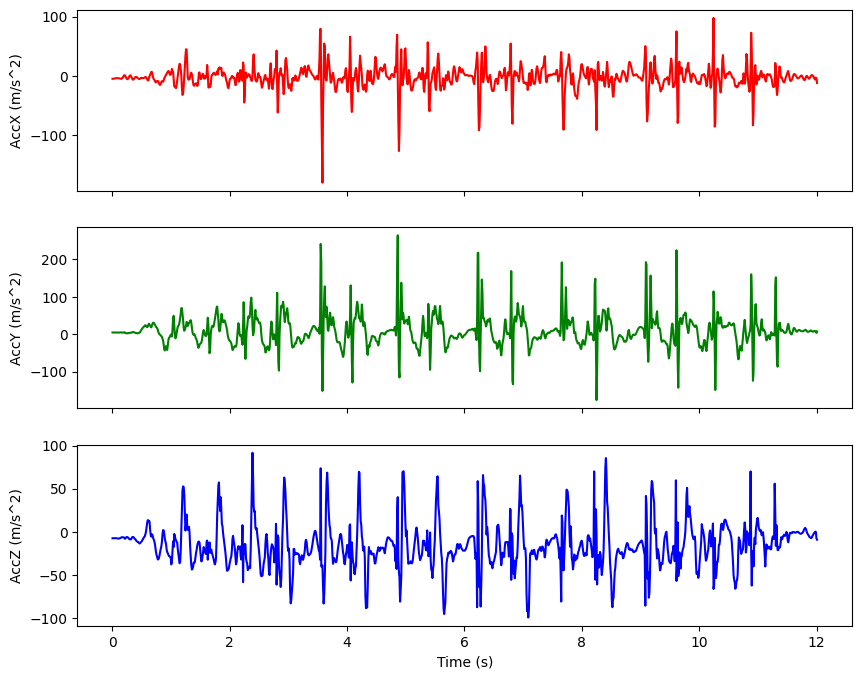

In [5]:
# plot on 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(df['Time (s)'], df[x_chan], color='r')
axs[0].set_ylabel('AccX (m/s^2)')
axs[1].plot(df['Time (s)'], df[y_chan], color='g')
axs[1].set_ylabel('AccY (m/s^2)')
axs[2].plot(df['Time (s)'], df[z_chan], color='b')
axs[2].set_ylabel('AccZ (m/s^2)')
axs[2].set_xlabel('Time (s)')
plt.show()

Let's use Scipy's find_peaks() function to identify peaks in the signal.

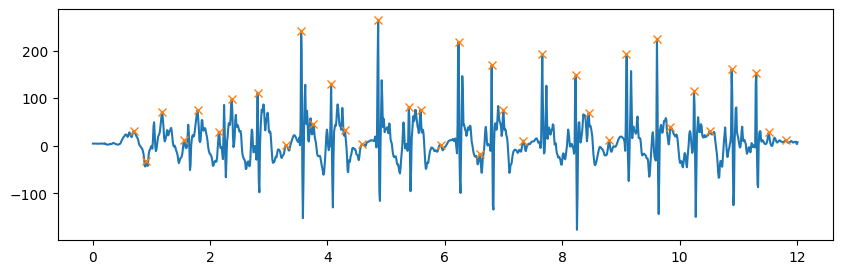

In [6]:
peaks, _ = find_peaks(df[y_chan], distance=20, prominence=4)

plt.plot(df['Time (s)'], df[y_chan])
plt.plot(df['Time (s)'].iloc[peaks], df[y_chan].iloc[peaks], 'x')

we can also flip the signal to find the negative peaks, then use the combination to be more robust.

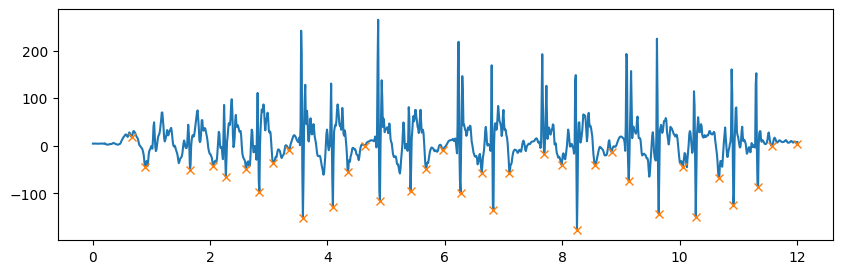

In [7]:
peaks, _ = find_peaks(-1*df[y_chan], distance=20, prominence=4)

plt.plot(df['Time (s)'], df[y_chan])
plt.plot(df['Time (s)'].iloc[peaks], df[y_chan].iloc[peaks], 'x')

Let's try filtering the signal

In [8]:
def standardize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def remove_outliers(signal, thresh = 3):
    return signal[np.abs(signal - np.mean(signal)) < thresh * np.std(signal)]

def butterworth_filter(signal, lowcut, highcut, fs, order=4):
    '''"Biometrics Analysis V.1"
    Apply a Butterworth band-pass filter to the signal.
    Parameters:
    signal : array-like
        The input signal to be filtered.
    lowcut : float
        The low cutoff frequency of the filter, in Hz.
    highcut : float
        The high cutoff frequency of the filter, in Hz.
    fs : float
        The sampling frequency of the signal.
    order : int, optional
        The order of the filter. Default is 4.
    Returns:
    array-like
        The filtered signal.
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    y = filtfilt(b, a, signal)
    return y

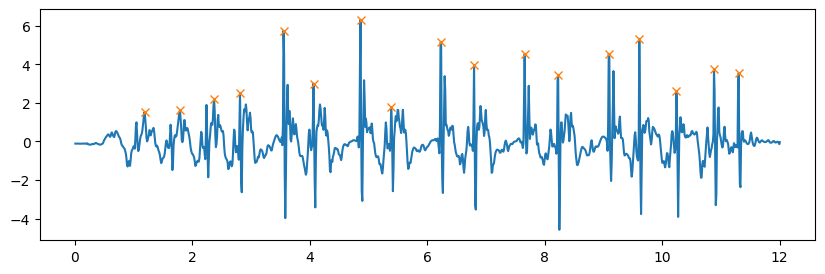

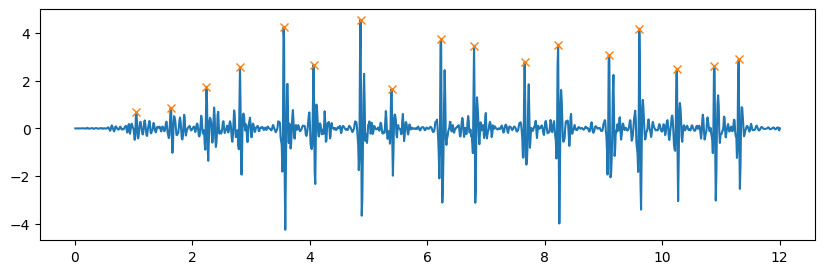

In [9]:
raw = standardize(df[y_chan])
peaks_raw, _ = find_peaks(raw, distance=25, prominence=1)
plt.plot(df['Time (s)'], raw)
plt.plot(df['Time (s)'].iloc[peaks_raw], raw[peaks_raw], 'x')
plt.show()

filtered = butterworth_filter(raw, lowcut=10, highcut=35, fs=calc_samplerate(df), order=4)
peaks, _ = find_peaks(filtered, distance=25, prominence=1)
plt.plot(df['Time (s)'], filtered)
plt.plot(df['Time (s)'].iloc[peaks], filtered[peaks], 'x')
plt.show()

in the above, notice how in the unfiltered data there is a "double peak" that is inconsitently detected (sometimes the first peak, sometimes the second). After filtering, this is more stable.

Next let's try using removing/inserting peaks based on the median peak distance

In [10]:
def clean_peaks(peaks, tolerance_factor=2):
    # Iterate through peaks. If interpeak interval is close to median, keep both peaks. 
    # If its close to 2x median, insert a peak in between.
    # else, discard.
    median_peak_distance = np.median(np.diff(peaks))
    tolerance = tolerance_factor * median_peak_distance * np.std(np.diff(peaks)) / np.mean(np.diff(peaks))
    cleaned_peaks = []
    i = 0
    while i < len(peaks) - 1:
        interval = peaks[i+1] - peaks[i]
        if np.isclose(interval, median_peak_distance, atol=tolerance):
            cleaned_peaks.append(peaks[i])
            i += 1
        elif np.isclose(interval, 2*median_peak_distance, atol=2*tolerance):
            cleaned_peaks.append(peaks[i])
            # Insert a peak in between
            mid_peak = (peaks[i] + peaks[i+1]) // 2
            cleaned_peaks.append(mid_peak)
            i += 1
        else:
            i += 1
    # Append the last peak if it wasn't added
    if i == len(peaks) - 1:
        cleaned_peaks.append(peaks[-1])
    return np.array(cleaned_peaks)

def reverse_peaks(peaks, len_signal):
    return (len_signal - peaks)[::-1]

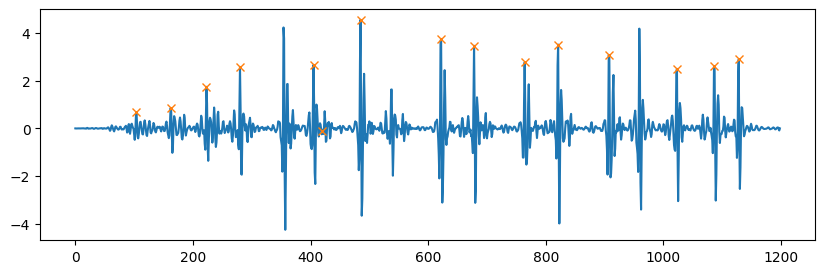

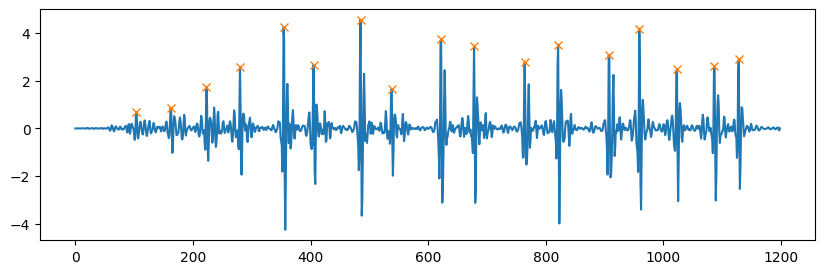

In [ ]:
raw = standardize(df[y_chan])
filtered = butterworth_filter(raw, lowcut=10, highcut=35, fs=calc_samplerate(df), order=4)
peaks, _ = find_peaks(filtered, distance=25, prominence=1)

# pretend we missed one and had an extra
missing_peaks = list(peaks)
missing_peaks.pop(4)
missing_peaks.pop(6)
missing_peaks.pop(11)
missing_peaks.append(missing_peaks[4] + 15)  # add an extra peak
missing_peaks = sorted(missing_peaks)
plt.plot(filtered)
plt.plot(missing_peaks, filtered[missing_peaks], 'x')
plt.show()

# run the cleaning function backwards and forwards to catch both extra and missing peaks
cleaned_peaks = clean_peaks(peaks, tolerance_factor=2)
cleaned_peaks = reverse_peaks(clean_peaks(reverse_peaks(cleaned_peaks, len(filtered))), len(filtered))

plt.plot(filtered)
plt.plot(cleaned_peaks, filtered[cleaned_peaks], 'x')

plt.show()

Handle Video

In [12]:
import cv2

# Load the video
video_path = os.path.join(data_dir, folder, folder + '.MOV')
cap = cv2.VideoCapture(video_path)

#get frame rate
video_fps = cap.get(cv2.CAP_PROP_FPS)
signal_fs = 100

print(f'Length of video: {cap.get(cv2.CAP_PROP_FRAME_COUNT)/video_fps} seconds')
print(f'Length of signal: {len(raw)/signal_fs} seconds')

Length of video: 20.77 seconds
Length of signal: 11.99 seconds


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Parameters
offset = 6.15  # Time offset between video start and signal start (in seconds)
interval = 1  # Time between frames to display (in seconds)
half_window = 100  # Half-window size for signal plot
offset_step = 0.1  # Step size when adjusting offset via buttons

# Calculate total number of frames available
video_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / video_fps
total_frames = int(video_duration / interval)

# Create interactive navigation
current_frame = [0]  # Use list to make it mutable in nested function

def get_frame_at_time(time_sec):
    """Load a single frame at the specified time."""
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(time_sec * video_fps))
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame
    return None

def show_frame(frame_idx):
    """Display the frame and corresponding signal window."""
    frame_idx = int(frame_idx)
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 4)

    # Get video frame at this time
    video_time = frame_idx * interval
    frame = get_frame_at_time(video_time)

    if frame is not None:
        ax[0].imshow(frame)
    else:
        ax[0].text(0.5, 0.5, 'Frame not available', ha='center', va='center')

    # Calculate signal window center
    signal_time = video_time - offset
    signal_window_center = int(signal_time * signal_fs + half_window)

    # Bounds checking for signal
    start_idx = max(0, signal_window_center - half_window)
    end_idx = min(len(raw), signal_window_center + half_window)

    if end_idx > start_idx:
        x_range_sec = np.arange(start_idx, end_idx) / signal_fs
        ax[1].plot(x_range_sec, raw[start_idx:end_idx])
    else:
        ax[1].text(0.5, 0.5, 'Signal window out of range', ha='center', va='center')

    if 0 <= signal_window_center < len(raw):
        ax[1].axvline(signal_window_center / signal_fs, color='r', linestyle='--')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Standardized Accel')
    ax[1].legend([y_chan])
    ax[0].set_title(f'Frame {frame_idx + 1} (Video: {video_time:.2f}s | Signal: {signal_time:.2f}s)')
    ax[1].set_title('Signal Offset: {:.2f} s'.format(offset))
    plt.tight_layout()
    plt.show()

output = widgets.Output()

def on_previous(b):
    with output:
        clear_output(wait=True)
        current_frame[0] = max(0, int(current_frame[0]) - 1)
        show_frame(current_frame[0])


def on_next(b):
    with output:
        clear_output(wait=True)
        current_frame[0] = min(total_frames - 1, int(current_frame[0]) + 1)
        show_frame(current_frame[0])


def on_interval_change(change):
    global interval, total_frames
    try:
        new_interval = float(change['new'])
        if new_interval > 0:
            current_video_time = current_frame[0] * interval
            interval = new_interval
            total_frames = max(1, int(video_duration / interval))
            current_frame[0] = min(total_frames - 1, max(0, round(current_video_time / interval)))
            with output:
                clear_output(wait=True)
                show_frame(current_frame[0])
    except ValueError:
        pass


def change_offset(delta):
    global offset
    offset += delta
    with output:
        clear_output(wait=True)
        show_frame(current_frame[0])


def on_offset_step_change(change):
    global offset_step
    try:
        new_step = float(change['new'])
        if new_step > 0:
            offset_step = new_step
    except ValueError:
        pass

prev_button = widgets.Button(description="← Previous")
next_button = widgets.Button(description="Next →")
prev_button.on_click(on_previous)
next_button.on_click(on_next)

interval_input = widgets.Text(
    value=str(interval),
    description='Interval (s):',
    continuous_update=False
)
interval_input.observe(on_interval_change, names='value')

offset_dec = widgets.Button(description="Offset -")
offset_inc = widgets.Button(description="Offset +")
offset_dec.on_click(lambda b: change_offset(-offset_step))
offset_inc.on_click(lambda b: change_offset(offset_step))

offset_step_input = widgets.Text(
    value=str(offset_step),
    description='Offset step (s):',
    continuous_update=False
)
offset_step_input.observe(on_offset_step_change, names='value')

nav_row = widgets.HBox([prev_button, next_button, interval_input])
offset_row = widgets.HBox([offset_dec, offset_inc, offset_step_input])
display(nav_row, offset_row, output)

with output:
    show_frame(current_frame[0])

Output()

In [14]:
hurdles = [
    (3.05, 3.50),
    (4.3, 4.8),
    (5.7, 6.2),
    (7, 7.6),
    (8.5, 9.1) 
]


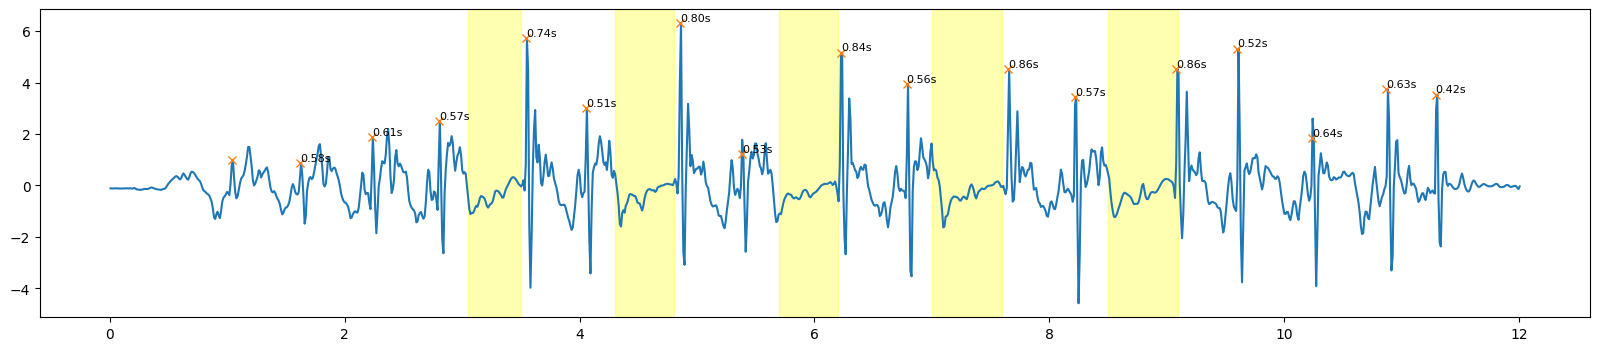

In [20]:
# make plot wider
plt.figure(figsize=(20, 4))
cleaned_peaks = peaks

# plot raw with time
raw = standardize(df[y_chan])
x = df['Time (s)']
plt.plot(x, raw)
plt.plot(cleaned_peaks / calc_samplerate(df), raw[cleaned_peaks], 'x')


#next to each peak display the time delta between peaks
for i in range(1, len(cleaned_peaks)):
    peak_time = cleaned_peaks[i] / calc_samplerate(df)
    prev_peak_time = cleaned_peaks[i-1] / calc_samplerate(df)
    delta_time = peak_time - prev_peak_time
    plt.text(peak_time, raw[cleaned_peaks[i]], f'{delta_time:.2f}s', fontsize=8, verticalalignment='bottom')
    
# plot hurdle zones
for start, end in hurdles:
    plt.axvspan(start, end, color='yellow', alpha=0.3)